# 2022-09-15 • Two-pass connection test: ptp, then corr with found avg

Two-pass connection test: peak-to-peak, then correlation with found average

## Imports

In [6]:
#

In [7]:
using MyToolbox

In [8]:
using VoltoMapSim

## Params

In [9]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [14]:
@time s = cached(sim, [p.sim]);

Loading cached output from `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\ce5e30aee45561ed.jld2` … done (1.8 s)
  1.799546 seconds (458.43 k allocations: 2.439 GiB, 28.60% gc time, 3.96% compilation time: 19% of which was recompilation)


In [13]:
s

In [17]:
@time s = augment(s, p);

  0.054799 seconds (19.16 k allocations: 25.912 MiB)


## First pass: peak-to-peak

Let's start with just neuron 1 as postsyn.

In [9]:
m = 1;

In [10]:
perf = cached_conntest_eval(s,m,p);

In [12]:
p.conntest.STA_test_statistic

"ptp"

In [21]:
ENV["LINES"] = 4
perf.tested_neurons

,input_neuron_ID,real_type,predicted_type,pval,area_over_start
,Int64,Symbol,Symbol,Float64,Float64
1,139,exc,exc,0.01,17
2,681,exc,inh,0.01,-4
3,11,exc,exc,0.01,18
4,766,exc,exc,0.01,52
⋮,⋮,⋮,⋮,⋮,⋮


We take all inputs with `predicted_type` :exc.

Current pval threshold is 0.05.  
We could be stricter.

It'll be tradeoff: stricter threshold gives less STAs to average to build our template;
but there will be less noisy STAs mixed in (or even wrong STAs, i.e. of non-inputs).

Now
- Get the :exc input detections for neuron 1
- Average their STA
- Apply this template to STAs of all inputs

In [22]:
# But first: cache STAs :)

In [18]:
SimData = typeof(s);

In [19]:
function get_tested_connections(s::SimData, p::ExpParams)
    # We do not test all N x N connections (that's too much).
    # The connections we do test are determined by which neurons
    # we record the voltage off, and the `N_tested_presyn` parameter.
    
    tested_connections = DataFrame(
        post     = Int[],     # neuron ID  
        pre      = Int[],     # neuron ID
        conntype = Symbol[],  # :exc or :inh or :unconn
        posttype = Symbol[],  # :exc or :inh
    )
    
    @unpack N_tested_presyn, rngseed = p.conntest
    
    resetrng!(rngseed)
    
    function get_labelled_sample(input_neurons, conntype)
        # Example output: `[(3, :exc), (5, :exc), (12, :exc), …]`.
        N = min(length(input_neurons), N_tested_presyn)
        inputs_sample = sample(input_neurons, N, replace = false, ordered = true)
        zip(inputs_sample, fill(conntype, N))
    end
    
    recorded_neurons = keys(s.v) |> collect |> sort!
    
    for post in recorded_neurons
        
        posttype = s.neuron_type[post]
        
        inputs_to_test = chain(
            get_labelled_sample(s.exc_inputs[post], :exc),
            get_labelled_sample(s.inh_inputs[post], :inh),
            get_labelled_sample(s.non_inputs[post], :unconn),
        ) |> collect
        
        for (pre, conntype) in inputs_to_test
            push!(tested_connections, (; post, pre, conntype, posttype))
        end
    end
    
    return tested_connections
end

tc = get_tested_connections(s, p)

disp(tc, 3)

,post,pre,conntype,posttype
,Int64,Int64,Symbol,Symbol
1,1,139,exc,exc
2,1,681,exc,exc
3,1,11,exc,exc
⋮,⋮,⋮,⋮,⋮


In [83]:
using Base.Threads

function calc_all_STAs(s::SimData, p::ExpParams)
    # Multi-threaded calculation of the real and shuffled STAs of all tested connections.
    #
    # We use a Channel to gather calculations,
    # as inserting items into a Dict is not thread-safe.
    @unpack rngseed, num_shuffles = p.conntest
    tc = tested_connections = get_tested_connections(s, p)
    recorded_neurons = unique(tested_connections.post)
    ch = Channel(Inf)  # `Inf` size, so no blocking on insert
    pbar = Progress(nrow(tested_connections), desc = "Calculating STAs: ")
    @info "Using $(nthreads()) threads"
    @threads(
    for m in recorded_neurons
        v = s.v[m]
        inputs_to_test = tc.pre[tc.post .== m]
        for n in inputs_to_test
            spikes = s.spike_times[n]
            real_STA = calc_STA(v, spikes, p)
            shuffled_STAz = Vector(undef, num_shuffles)  # [1]
            resetrng!(rngseed)
            for i in 1:num_shuffles
                shuffled_spikes = shuffle_ISIs(spikes)
                shuffled_STAz[i] = calc_STA(v, shuffled_spikes, p)
            end
            put!(ch, ((n => m), real_STA, shuffled_STAz))
            next!(pbar)
        end
    end)
    # Empty the channel, into the output dicts
    STAs          = Dict{Pair{Int, Int}, Vector{Float64}}()
    shuffled_STAs = Dict{Pair{Int, Int}, Vector{Vector{Float64}}}()
    while !isempty(ch)
        conn, real, shuffleds = take!(ch)
        STAs[conn]          = real
        shuffled_STAs[conn] = shuffleds
    end
    close(ch)
    
    return (; tested_connections, STAs, shuffled_STAs)
end

# [1] Giving this the same name as the output dict, in combination with `@threads`,
# confuses type inference and infers `Any` for the `shuffled_STAs` output dict.

calc_all_STAs (generic function with 1 method)

In [12]:
# For 4000 connections tested (0.4% of all) and 100 shuffles,
# we get 404_000 STAs.
# At 1000 Float64 samples per STA, that is 3.2 GB.

In [11]:
out = cached(calc_all_STAs, [s,p], key=[p.sim, p.conntest]);

[ Info: Using 7 threads
Calculating STAs: 100%|█████████████████████████████████| Time: 0:16:23
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\calc_all_STAs\b9353bdd11d8b8cb.jld2` … done (11.5 s)


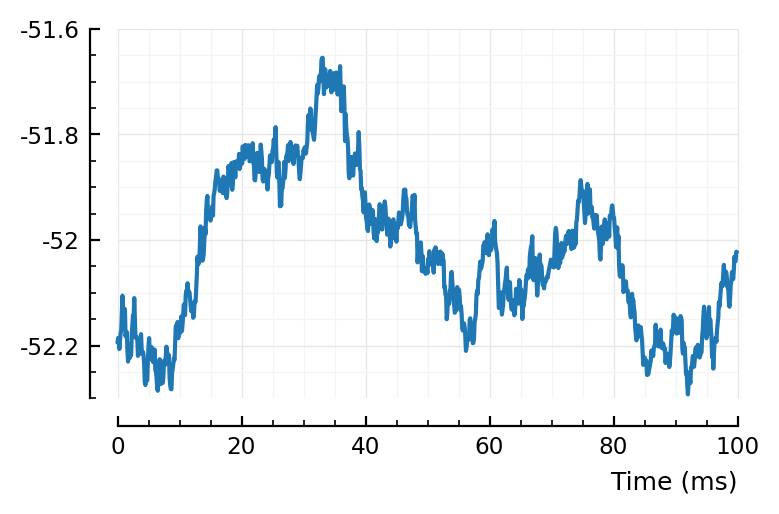

In [25]:
plotsig(out.STAs[139=>1] / mV, p);